In [46]:
import data_handler
import machine_learning as ml
import cost_benefit as cb

import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib
import graphviz 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Main results for seminar paper
This notebook is created to estimate the machine learning models for the chosen hyperparameters. See other notebook for invokement of the grid search algorithm to choose the optimal hyperparameters.

In [2]:
# First, define wrapper to call all necessary functions.
def result_wrapper(model, parameters, train, test, name, baseline=None, scoring='recall'):
    x, y = train[0], train[1]

    # I have to create a fake class in order to make validate model work.
    # This is because it was created with the purpose to work with the
    # grid search algorithm.
    class Object(object):
        pass
    model_obj = Object()
    model_obj.best_estimator_ = model(**parameters).fit(x, y)
    best_model = ml.validate_model(model_obj, train, test, scoring=scoring, supress_print=True)
    benefits = cb.cost_benefit_analysis(best_model, test)

    # Print latex friendly table
    print(f"{name} & {benefits[3]} & {benefits[0]:.2f} & {benefits[1]/benefits[0]*100:.2f} & {benefits[2]/benefits[0]*100:.2f} \\\\")
    if not baseline:
        cb.latex_printout(best_model, (train, test), name)
    else:
        cb.latex_printout_baseline(best_model, (train, test), name, baseline)
    return best_model

### Ohlson's Logit
I first define a function to run Ohlson's logit function, with the specified variables. I then evaluate it both in it's success at predicting bankruptcies, but also how much savings we expect.

In [3]:
def ohlson_data(year):
    x_train, x_test, y_train, y_test = data_handler.load_data(year)
    n = y_train.size
    x_train.columns = data_handler.ohlson_varnames()
    x_test.columns = data_handler.ohlson_varnames()

    # Ohlson use a dummy if liabilites are greater than assets
    x_train['liabilites > assets'] = (x_train['total liabilities / total assets'] > 1)*1.0
    x_test['liabilites > assets'] = (x_test['total liabilities / total assets'] > 1)*1.0

    # Try to replicate the variables as closely as possible,
    # some of the variables are inverted, but that should not affect
    # the predictability, only the sign of the coefficient.
    ohlson_vars = [
        'logarithm of total assets', 
        'total liabilities / total assets', 
        'working capital / total assets', 
        'current assets / short-term liabilities',
        'liabilites > assets',
        'net profit / total assets',
        'total liabilities / ((profit on operating activities + depreciation) * (12/365))',
        'sales (n) / sales (n-1)'
    ]
    x_ohlson_train = x_train[ohlson_vars]
    x_ohlson_test = x_test[ohlson_vars]
    return x_ohlson_train, x_ohlson_test, y_train, y_test

In [4]:
x_train, x_test, y_train, y_test = ohlson_data(5)
ohlson_parameters = {'penalty': 'none', 'max_iter': 1000}
result_wrapper(LogisticRegression, ohlson_parameters, (x_train, y_train), (x_test, y_test), "Ohlson's logit", scoring='roc_auc') ;

Ohlson's logit & 3 & 68.71 & 0.10 & 0.17 \\
\begin{table}[!hb]
\centering
\label{tab:Ohlson's logit}
\caption{Confusion matrix for Ohlson's logit model} 
\caption*{Train Results with area under the curve score of 0.799}
\begin{tabular}{lcc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt \\
\hline
Non-Bankrupt & $\underset{(0.995)}{4379}$ & $\underset{(0.005)}{21}$ \\ 
Bankrupt & $\underset{(0.933)}{306}$ & $\underset{(0.067)}{22}$ \\ 
\hline
\end{tabular}
\caption*{Test Results with area under the curve score of 0.762}
\begin{tabular}{lcc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt \\
\hline
Non-Bankrupt & $\underset{(0.995)}{1095}$ & $\underset{(0.005)}{5}$ \\ 
Bankrupt & $\underset{(0.963)}{79}$ & $\underset{(0.037)}{3}$ \\ 
\hline
\end{tabular}
\medskip

\footnotesize\noindent
Note: Results from Ohlson's logit model plotted as a confusion matrix. Each cell contains the number of firms, with row percentages in the paranthesis.
\end{table}


### Logit with elastic net
This is an extension of Ohlson's logit model. This time we include all available variables. Since this can lead to overfitting, we use elastic-net to reduce this problem.

In [5]:
x_train, x_test, y_train, y_test = data_handler.load_data(5, out_frame=False)
logit_parameters = {
    'C': 1.2, 
    'l1_ratio': 0,
    'penalty': 'elasticnet', 
    'solver': 'saga',
    'max_iter': 500
}
logit_best_model = result_wrapper(LogisticRegression, logit_parameters, (x_train, y_train), (x_test, y_test), "Logit", scoring='roc_auc')

/Users/karl/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
Logit & 9 & 68.71 & 0.46 & 0.77 \\
\begin{table}[!hb]
\centering
\label{tab:Logit}
\caption{Confusion matrix for Logit model} 
\caption*{Train Results with area under the curve score of 0.817}
\begin{tabular}{lcc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt \\
\hline
Non-Bankrupt & $\underset{(0.995)}{4378}$ & $\underset{(0.005)}{22}$ \\ 
Bankrupt & $\underset{(0.918)}{301}$ & $\underset{(0.082)}{27}$ \\ 
\hline
\end{tabular}
\caption*{Test Results with area under the curve score of 0.772}
\begin{tabular}{lcc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt \\
\hline
Non-Bankrupt & $\underset{(0.995)}{1094}$ & $\underset{(0.005)}{6}$ \\ 
Bankrupt & $\underset{(0.89)}{73}$ & $\underset{(0.11)}{9}$ \\ 
\hline
\end{tabular}
\meds

This prints the most important logit coefficients

In [6]:
def print_important_coeff(model, n_coeffs):
    important_coeff_arg = np.flip(
        np.argsort(np.abs(logit_best_model['estimator'].coef_))
    )
    coeff_names = data_handler.ohlson_varnames()

    coeff_list = []
    name_list = []
    for i in range(0, n_coeffs + 1):
        coeff_arg = important_coeff_arg[0, i]
        coeff_list.append(round(logit_best_model['estimator'].coef_[0, coeff_arg], 3))
        name_list.append(coeff_names[i])
    return coeff_list, name_list

def print_two_rows(coeff_list, name_list):
    # Split list in two and rezip them
    zipped_list = list(zip(coeff_list, name_list))
    zipped1 = zipped_list[:5]
    zipped2 = zipped_list[5:]
    zipped_list2 = zip(zipped1, zipped2)
    table = tabulate(zipped_list2, tablefmt='latex')

    # Remove tuple and list specifiers
    for char in ["'", "(", ")", "[", "]"]:
        table = table.replace(char, '')

    # Make some small adjustments to get a pretty list
    table = table.replace("ll", "llll")
    table = table.replace(",", " &")
    table = table.replace("cash + short-term securities + receivables - short-term liabilities / operating expenses - depreciation * 365", "defensive interval ratio")
    # table = table.replace("'", '').replace("(", '').replace(")", '').replace("[","").replace("[","")
    print(table)

In [7]:
coeff_list, name_list = print_important_coeff(logit_best_model, 10)
print_two_rows(name_list, coeff_list)

\begin{tabular}{llll}
\hline
 net profit / total assets & -0.39                                                                                            & retained earnings / total assets & 0.267          \\
 total liabilities / total assets & -0.368                                                                                    & EBIT / total assets & -0.171                      \\
 working capital / total assets & -0.365                                                                                      & book value of equity / total liabilities & -0.131 \\
 current assets / short-term liabilities & -0.31                                                                              & sales / total assets & -0.128                     \\
 defensive interval ratio & -0.298 & equity / total assets & 0.122                     \\
\hline
\end{tabular}


In [8]:
dt_parameters = {
    'max_leaf_nodes': 11,  #19
    'max_depth': 5,  #7
    'min_samples_leaf': 0.01,
    'min_samples_split': 0.01,
    'min_weight_fraction_leaf': 0,
    'min_impurity_decrease': 0
}
dt_best_model = result_wrapper(
    DecisionTreeClassifier, dt_parameters, (x_train, y_train), (x_test, y_test), "Decision Tree", baseline=logit_best_model, scoring='roc_auc')

Decision Tree & 37 & 68.71 & 5.45 & 9.08 \\
\begin{table}[!hb]
\centering
\label{tab:Decision Tree}
\caption{Confusion matrix for Decision Tree model} 
\caption*{Train Results with area under the curve score of 0.898}
\begin{tabular}{lcc||lc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt & & \makecell{Baseline \\ comparison} \\
\hline
Non-Bankrupt & $\underset{(0.986)}{4337}$ & $\underset{(0.014)}{63}$ & \makecell{Type 1 \\ errors} & $\underset{(0.009)}{41}$ \\ 
Bankrupt & $\underset{(0.476)}{156}$ & $\underset{(0.524)}{172}$ & \makecell{Type 2 \\ errors} & $\underset{(-0.442)}{-145}$ \\ 
\hline
\end{tabular}
\vspace{1cm}
\caption*{Test Results with area under the curve score of 0.823}
\begin{tabular}{lcc||lc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt & & \makecell{Baseline \\ comparison} \\
\hline
Non-Bankrupt & $\underset{(0.975)}{1072}$ & $\underset{(0.025)}{28}$ & \makecell{Type 1 \\ errors} & $\underset{(0.02)}{22}$ \\ 
Bankrupt & $\unde

In [9]:
dot_data = tree.export_graphviz(
    dt_best_model['estimator'], 
    out_file=None, 
    feature_names=data_handler.ohlson_varnames(),
    class_names=['non-bankrupt', 'bankrupt'],
    rounded=True, filled=True
) 
graph = graphviz.Source(dot_data) 
graph.render("bankruptcy") 

'bankruptcy.pdf'

### Gradient Descent classifier

In [10]:
GBC_parameters = {
    "learning_rate": 0.9,
    "min_samples_split": 0.005,
    "min_samples_leaf": 0.005,
    "max_depth": 8,
    'random_state': 42
}
gbc_results = result_wrapper(GradientBoostingClassifier, GBC_parameters, (x_train, y_train), (x_test, y_test), "Gradient Boosting", scoring='roc_auc', baseline=logit_best_model) ;

Gradient Boosting & 49 & 68.71 & 6.69 & 11.15 \\
\begin{table}[!hb]
\centering
\label{tab:Gradient Boosting}
\caption{Confusion matrix for Gradient Boosting model} 
\caption*{Train Results with area under the curve score of 1.000}
\begin{tabular}{lcc||lc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt & & \makecell{Baseline \\ comparison} \\
\hline
Non-Bankrupt & $\underset{(0.998)}{4391}$ & $\underset{(0.002)}{9}$ & \makecell{Type 1 \\ errors} & $\underset{(-0.003)}{-13}$ \\ 
Bankrupt & $\underset{(0.085)}{28}$ & $\underset{(0.915)}{300}$ & \makecell{Type 2 \\ errors} & $\underset{(-0.833)}{-273}$ \\ 
\hline
\end{tabular}
\vspace{1cm}
\caption*{Test Results with area under the curve score of 0.933}
\begin{tabular}{lcc||lc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt & & \makecell{Baseline \\ comparison} \\
\hline
Non-Bankrupt & $\underset{(0.983)}{1081}$ & $\underset{(0.017)}{19}$ & \makecell{Type 1 \\ errors} & $\underset{(0.012)}{13}$ \\ 
Ban

### Neural network


In [11]:
nn_parameters = {
    'solver': 'lbfgs',
    'random_state': 42,
    'warm_start': False,
    'hidden_layer_sizes': 190,
    'max_iter': 200
}
nn_results = result_wrapper(MLPClassifier, nn_parameters, (x_train, y_train), (x_test, y_test), "Neural network", scoring='roc_auc', baseline=logit_best_model) ;

/Users/karl/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
Neural network & 42 & 68.71 & 6.70 & 11.17 \\
\begin{table}[!hb]
\centering
\label{tab:Neural network}
\caption{Confusion matrix for Neural network model} 
\caption*{Train Results with area under the curve score of 0.999}
\begin{tabular}{lcc||lc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt & & \makecell{Baseline \\ comparison} \\
\hline
Non-Bankrupt & $\underset{(0.992)}{4366}$ & $\underset{(0.008)}{34}$ & \makecell{Type 1 \\ errors} & $\underset{(0.003)}{12}$ \\ 
Bankrupt & $\underset{(0.159)}{52}$ & $\underset{(0.841)}{276}$ & \makecell{Type 2 \\ erro

In [113]:
def roc_plotter(
    test_data: tuple, 
    models: list, 
    figsize=(10, 7.5), 
    linewidth=2.5, 
    color_list=['#377eb8', '#4daf4a',
         '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00'],
    name_list=['Logit', 'Decision Tree', 'Nerual Network', 'Gradient Booster']
    ):
    x_test, y_test = test_data
    fig, ax = plt.subplots(figsize=figsize)

    # Set options
    ax.set_xlim(-0.005, 1)
    ax.set_ylim(0, 1.008)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    matplotlib.rcParams.update({'font.size': 16})
    matplotlib.rcParams.update({'font.size': 16})

    # Allow for multiple models in each plot
    for i, model in enumerate(models):
        y_pred = model['estimator'].predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred[:, 1])

        # name = model['estimator'].__class__.__name__
        name = name_list[i]
        ax.plot(fpr, tpr, linewidth=linewidth, label=f"{name}: {model['test_score']:.3f}", color=color_list[i])
        ax.legend(loc='lower right', frameon=False)
    ax.plot([0, 1], [0, 1], linewidth=linewidth, color='grey')  # 45-deg line
    plt.savefig('roc_curves.png')
    plt.show()

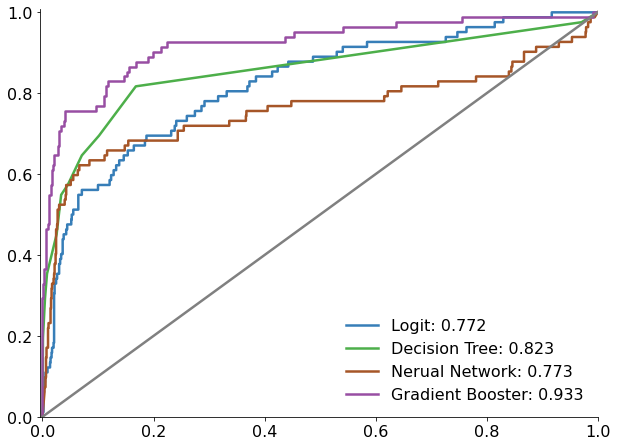

In [114]:
roc_plotter((x_test, y_test), [logit_best_model, dt_best_model, nn_results, gbc_results])
